# 哈尔滨工业大学（深圳）《统计机器学习》2023 春 实验二


In [1]:
# | echo: false

# 切换为矢量图
import matplotlib_inline
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg")


## 实验分析

本次实验的内容是使用 ID3 等算法实现决策树，并使用决策树对银行借贷数据集进行分类。

首先，用 Pandas 加载数据集，观察其特征。


In [2]:
import numpy as np
import pandas as pd
import math

df = pd.read_excel("实验二资料/银行借贷数据集train.xls")
df = df.drop(['nameid'], axis=1)
re = [0, 10000, 20000, 30000, 40000, 50000]
df['revenue'] = pd.cut(df['revenue'], re, labels=False)
df


profession  education  house_loan  car_loan  married  child  revenue   
0             5          1           0         0        1      1        0  \
1             3          1           1         1        0      0        0   
2             2          3           1         0        1      0        1   
3             2          2           0         0        0      0        4   
4             4          2           0         1        0      1        1   
..          ...        ...         ...       ...      ...    ...      ...   
795           5          3           0         1        1      0        2   
796           5          5           0         0        1      1        3   
797           1          1           0         0        1      0        2   
798           3          5           0         1        0      0        1   
799           1          4           0         0        1      0        3   

     approve  
0          1  
1          0  
2          1  
3          1  
4          0  
..       ...  
795        1  
796        1  
797        1  
798        1  
799        1  

[800 rows x 8 columns]

然后用 seaborn 绘制特征两两配对的散点图。


In [3]:
import seaborn as sns
sns.pairplot(df, hue='approve')


从上面的配对图中可以看出，本次实验数据集中的数据除了 revenue 以外均是离散的，不仅不是线性可分，重合度还非常高，不能通过简单的感知机模型进行分类。


## Python 自编程实现决策树学习

首先实现一个熵函数，用于计算信息熵。实际上条件熵的计算可以通过在传入 `df` 参数前先进行筛选来实现，因此此处不单独写出。


In [4]:
def entropy(df: pd.DataFrame, column: str):
    """
    计算信息熵
    :param df: 数据集，通过传入子集来实现条件信息熵
    :param column: 特征名（即列名
    """
    result = 0
    for val in df[column].unique():
        p = df[df[column] == val].shape[0]/df.shape[0]
        result += -p*math.log(p, 2)
    return result


for column in df.columns[:-1]:
    print(f"Entropy of {column} is {entropy(df, column)}")

print(f"Entropy of approve is {entropy(df, 'approve')}")


Entropy of profession is 2.3160461194481092
Entropy of education is 2.320769231096084
Entropy of house_loan is 0.9999819662368479
Entropy of car_loan is 0.9998376907209825
Entropy of married is 0.9983718470809948
Entropy of child is 0.9969501570069956
Entropy of revenue is 2.2081053837956643
Entropy of approve is 0.9362809717771063


接下来，使用 ID3 算法构建决策树。

此处没有使用面向对象的写法，而是使用了函数式编程的范式，因为 ID3 算法生成的决策树只有两种节点：带有终值的叶节点，和带有根据某一列的所有可能值进入不同分支的非叶节点。显然，这一结构通过元组即可进行表示：带有一个元素的元组为叶节点，其元素即为终值；而带有两个元素的元组为非叶节点，第一个元素为判断依据的特征（列），第二个元素为该元素所有可能的值与对应的子树的映射，另外如果有剪枝的需求，可以为元组加上表示当前节点值的第三个元素。

```fsharp
// 以下仅作演示
// 'result 为叶节点终值的类型
type DecisionTreeNode<'result> =
    | Leaf of 'result // 叶节点
    | NonLeaf of string * Map<string, DecisionTreeNode> * 'result // 非叶节点
```


In [5]:
def build_id3(df: pd.DataFrame,
              columns: pd.Index) -> tuple[int] | tuple[str, dict, int]:
    """
    通过 ID3 算法构建决策树
    :param df: 数据集 D，可以是子集
    :param columns: 剩余的可以用于划分的特征 A
    :return: 表示叶节点的单元组或非叶节点的三元组
    """
    # 检查是否为空
    if df.shape[0] == 0:
        return (None, )
    # 检查是否完全是同一类
    if len(df['approve'].unique()) <= 1:
        return (df['approve'].unique()[0], )
    # 检查是否没有特征
    if columns.shape[0] == 0:
        return (df['approve'].value_counts()
                .sort_values(ascending=False).index[0], )

    # 计算信息增益
    approve_entropy = entropy(df, 'approve')
    max_feature = None
    max_feature_gain = 0
    for column in columns:
        max_feature_value = None
        # max_feature_value_gain = 0
        max_feature_value_len = 0
        feature_gain = 0
        for val in df[column].unique():
            val_len = df[df[column] == val].shape[0]
            p = val_len/df.shape[0]
            val_gain = approve_entropy - \
                entropy(df[df[column] == val], 'approve')
            feature_gain += p*val_gain
            if val_len > max_feature_value_len:
                max_feature_value_len = val_len
                max_feature_value = val
        if feature_gain > max_feature_gain:
            max_feature_gain = feature_gain
            max_feature = column
            all_max_feature_value = max_feature_value

    # 检查 max_feature_entropy 是否小于 epsilon
    # 是则用整个数据集的 approve 作为 label
    if max_feature_gain < 0.03:
        return (df['approve'].value_counts()
                .sort_values(ascending=False).index[0], )
    else:
        return (max_feature,
                {val: build_id3(df[df[max_feature] == val],
                                columns.drop(max_feature))
                 for val in df[max_feature].unique()},
                df['approve'].value_counts()
                .sort_values(ascending=False).index[0])


train_df, validate_df = np.split(df.sample(
    frac=1, random_state=1), [int(.7*len(df))])
dt = build_id3(train_df, df.columns[:-1])
dt


('car_loan',
 {1: ('house_loan',
   {1: ('child',
     {1: (0,),
      0: ('revenue',
       {3: ('education',
         {3: (1,),
          5: (1,),
          2: (1,),
          4: ('profession', {2: (1,), 3: (0,)}, 1),
          1: ('profession', {4: (1,), 1: (0,)}, 1)},
         1),
        1: ('profession',
         {5: ('married',
           {0: ('education', {5: (1,), 1: (1,), 2: (0,), 4: (1,)}, 1),
            1: (0,)},
           1),
          1: (1,),
          3: (1,),
          2: ('education', {3: (0,), 2: (1,), 1: (0,)}, 0)},
         1),
        0: ('profession',
         {5: ('education',
           {5: ('married', {0: (0,), 1: (1,)}, 0), 1: (1,), 2: (1,), 4: (1,)},
           1),
          3: (0,),
          1: ('education', {2: (0,), 4: (0,), 3: (0,), 1: (1,)}, 0),
          4: (0,)},
         0),
        4: (1,),
        2: ('profession',
         {1: (1,),
          2: (0,),
          3: ('education',
           {1: (1,), 2: ('married', {1: (0,), 0: (1,)}, 0), 5: (0,)

In [6]:
tp, tn, fp, fn = 0, 0, 0, 0
for index, row in validate_df.iterrows():
    t = dt
    # 推理核心代码
    while len(t) != 1:
        t = t[1].get(row[t[0]], (t[2],))
    predict = t[0]
    actual = row['approve']
    match (predict, actual):
        case (0, 0):
            tn += 1
        case (0, 1):
            fn += 1
        case (1, 0):
            fp += 1
        case (1, 1):
            tp += 1
print(f"P: {tp/(tp+fp)}, R: {tp/(tp+fn)}, F1: {2*tp/(2*tp+fp+fn)}")


P: 0.7371428571428571, R: 0.8657718120805369, F1: 0.7962962962962963


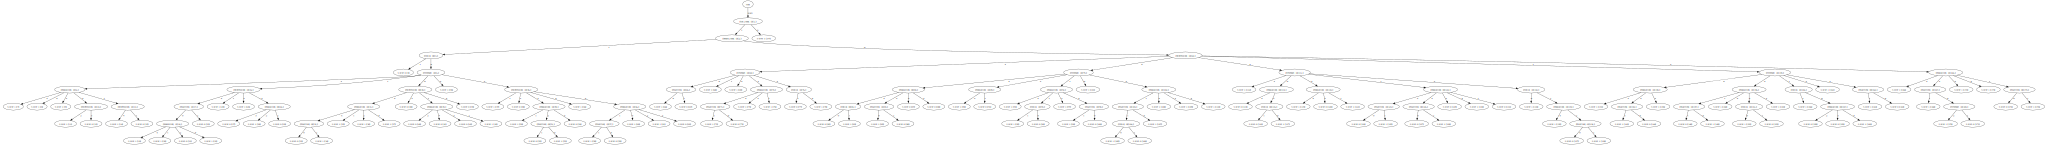

In [7]:
import graphviz

dt_graph = graphviz.Digraph()

node_index = 0


def draw_tree(t: tuple, parent: str,
              dt_graph: graphviz.Digraph, label: str = None):
    global node_index
    node_index += 1
    if len(t) == 1:
        dt_graph.edge(parent, f"Solve {t[0]} ({node_index})", label=label)
    else:
        node_name = str((t[0], t[2]))+str((node_index,))
        dt_graph.edge(parent, node_name, label=label)
        for k, v in t[1].items():
            draw_tree(v, node_name, dt_graph, label=str(k))


draw_tree(dt, 'root', dt_graph, "start")
dt_graph


## sklearn 实现决策树学习

sklearn 直接在 np.ndarray 上操作，可以非常方便的对它们进行训练测试集划分、训练效果评估，不过需要我们先将 Pandas 的 DataFrame 转换为 np.ndarray。


P: 0.5128205128205128, R: 0.9090909090909091, F1: 0.6557377049180326
P: 0.5555555555555556, R: 0.9183673469387755, F1: 0.6923076923076923
P: 0.8461538461538461, R: 0.8333333333333334, F1: 0.8396946564885497
P: 0.7439024390243902, R: 0.9104477611940298, F1: 0.8187919463087248
P: 0.9846153846153847, R: 0.7710843373493976, F1: 0.8648648648648649
P: 0.7625, R: 0.8840579710144928, F1: 0.8187919463087248
P: 0.7571428571428571, R: 0.8983050847457628, F1: 0.8217054263565892
P: 0.9863013698630136, R: 0.8888888888888888, F1: 0.935064935064935


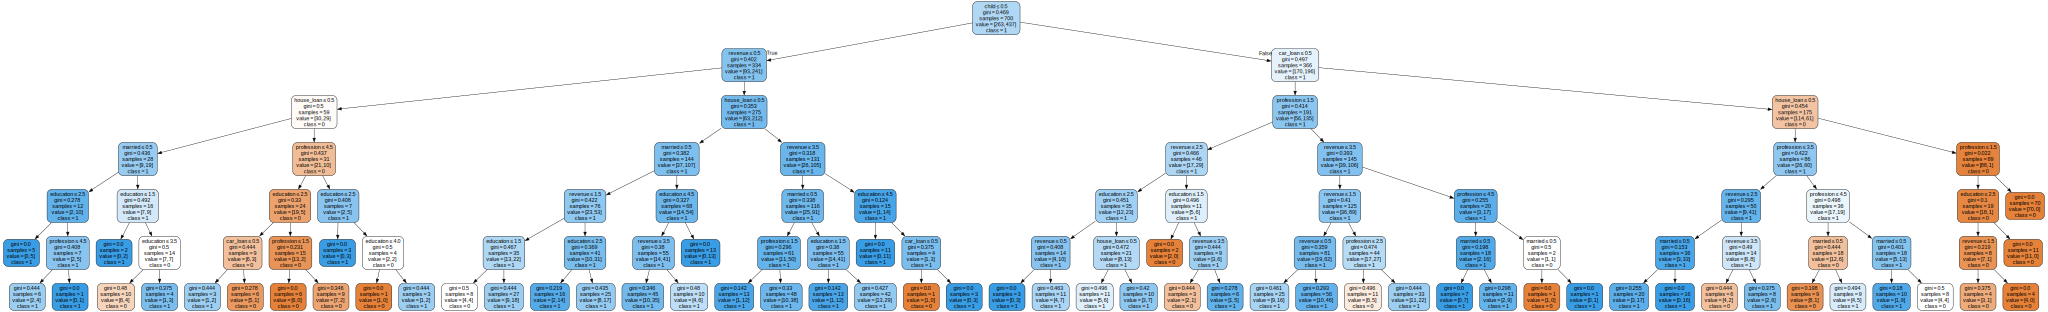

In [8]:
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn import metrics


tree_clf = DecisionTreeClassifier(max_depth=6)


kf = KFold(n_splits=8)
for train, test in kf.split(df):
    tree_clf.fit([row[:-1] for row in df.values[train]], [row[-1]
                 for row in df.values[train]])
    y_pred = tree_clf.predict([row[:-1] for row in df.values[test]])
    p = metrics.precision_score([row[-1] for row in df.values[test]], y_pred)
    r = metrics.recall_score([row[-1] for row in df.values[test]], y_pred)
    f1 = metrics.f1_score([row[-1] for row in df.values[test]], y_pred)
    print(f"P: {p}, R: {r}, F1: {f1}")

# 用最后一次训练的结果绘制图像
graphviz.Source(export_graphviz(
    tree_clf,
    out_file=None,
    feature_names=df.columns[:-1],
    class_names=['0', '1'],
    rounded=True,
    filled=True,
    special_characters=True))
